In [426]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.colors as col
import numpy as np
import scipy as sp
import pandas as pd
import time

from bisect import bisect_left



In [938]:
class TrafficSimulation():
    
    def __init__(self,road_size,lanes,density):
        global cars, sorted_ids
        
        self.road_size = road_size
        self.density = density
        self.time_step = 0
        self.lanes = lanes
        self.n_cars = round(self.road_size * self.density)
        self.road = -1*np.ones((lanes,road_size))
        
        self.initial_positions = np.random.choice(range(self.road_size),self.n_cars,replace=False)
            
        cars = [Car(id=i, position = np.array([lanes-1,initial_positions[i]]),vmax=5, p_slow = 0) for i in range(self.n_cars)]
        
        for car in cars:
            self.road[tuple(car.position)] = car.v
        
        
        self.car_positions = []
        for l in range(self.lanes):
            #self.car_positions.append({})
            cars_in_a_lane = list(filter(lambda x : x.position[0] == l, cars))
            self.car_positions.append([car.position[1] for car in sorted(cars_in_a_lane, key = lambda x : x.position[1])])
            #sorted_cars_in_a_lane = np.array([car.position[1] for car in sorted(cars_in_a_lane, key = lambda x : x.position[1])])
            #for c in sorted_cars_in_a_lane:
                #self.car_positions[l][cars[c].position[1]] = c
        
        #self.cars_left = list(filter(lambda x : x.position[0] == 0, cars))
        #self.cars_left = np.array([car.id for car in sorted(self.cars_left, key = lambda x : x.position[1])])
        
        #self.cars_right = list(filter(lambda x : x.position[0] == 1, cars))
        #self.cars_right = np.array([car.id for car in sorted(self.cars_right, key = lambda x : x.position[1])])        
        
        #print('left: ',self.cars_left)
        #print('right: ',self.cars_right)
        #self.sorted_ids = np.array([car.id for car in sorted(cars, key = lambda x : x.position)])
        
    def draw(self):
        
        
        C = np.array([[255,255,255],
            [235,198,83],
            [136,230,255],
            [0,200,255],
            [0,145,255],
            [0,92,205],
            [0,57,103]])
        
        cm = col.ListedColormap(C/255.0)
        
        self.fig, self.bars = plt.subplots(1, figsize=(15,7))
        self.bars.cla()
        im = self.bars.imshow(self.road,vmin = -1, vmax = 5, cmap = cm, interpolation='none')# plt.cm.binary)
        self.bars.axis('image')
        
        if self.lanes <= 3: self.bars.get_yaxis().set_visible(False)
        else: self.bars.set_yticks(range(0,self.road.shape[0]))
        self.bars.set_xticks(range(0,self.road.shape[1]+1,2))
        self.bars.set_title('t = ' + str(self.time_step)) 
        
        if self.time_step == 0:
            cbaxes = self.fig.add_axes([0, 0.7, 0.8, 0.02]) 
            cb = plt.colorbar(self.bars.imshow(self.road,vmin = -1, vmax = 5, cmap = cm)# plt.cm.binary)
            , cax = cbaxes, orientation = 'horizontal')  
        
        
        self.fig.subplots_adjust(left=0)

    def update_road_map(self):
        self.car_positions = []
        for l in range(self.lanes):
            cars_in_a_lane = list(filter(lambda x : x.position[0] == l, cars))
            self.car_positions.append([car.position[1] for car in sorted(cars_in_a_lane, key = lambda x : x.position[1])])
    

    def update_simulation(self):
        
        
        self.time_step += 1

        
        self.road.fill(-1)
        
        self.update_road_map()
        
        for car in cars:
            car.change_lane()
        
        
        self.update_road_map()
        
        for car in cars:
            car.update_v()
            #print(car.v)
        
        for car in cars:
            car.update_position()
        
            self.road[tuple(car.position)] = car.v
         
        
        
        
        
        
#         for car in cars:
#             car.change_lane()
#             car.update_v()
#             car.update_position()

            
        
        
        
        
        

class Car:
    
    def __init__(self, id, position, vmax, p_slow = 0.5):
        self.id = id
        self.position = position
        self.p_slow = p_slow
        
        self.back_car = -1
        
        self.front_car = -1
        
        self.v = 1
        self.vmax = vmax
        
    def periodic_distance(self,x,y,size = sim.road_size):
        return min(abs(x-y), x-y+size)
        
    def check_left(self):
        if self.position[0] == 0:
            return 0
        
        left_lane = self.position[0] - 1
        
        if len(sim.car_positions[left_lane]) == 0:
            self.left_gap = sim.road_size - 1
            return sim.road_size - 1
        
        front_idx = bisect_left(sim.car_positions[self.position[0]], self.position[1]) % len(sim.car_positions[self.position[0]])
        front_position = sim.car_positions[self.position[0]][front_idx]
        
        left_idx = bisect_left(sim.car_positions[left_lane], self.position[1]) % len(sim.car_positions[left_lane])
        left_position = sim.car_positions[left_lane][left_idx]
        
        back_idx = (left_idx - 1) % len(sim.car_positions[left_lane])
        back_position = sim.car_positions[self.position[left_lane]][back_idx]
        
        self.front_gap = self.periodic_distance(front_position, self.position[1]) - 1
        self.left_gap = self.periodic_distance(left_position, self.position[1]) -1
        self.back_gap = self.periodic_distance(back_position, self.position[1]) -1
        
        if self.front_gap < self.v + 1 and self.left_gap > self.v + 1 and self.back_gap > self.vmax:
            return left_gap - front_gap
        else:
            return 0
        
        
        
    
    def check_right(self):
        if self.position[0] == sim.lanes - 1:
            self.right_gap = sim.road_size - 1
            return 0
        
        right_lane = self.position[0] + 1
        
        if len(sim.car_positions[right_lane]) == 0:
            return sim.road_size - 1
        
        front_idx = (bisect_left(sim.car_positions[self.position[0]], self.position[1]) + 1) % len(sim.car_positions[self.position[0]])
        front_position = sim.car_positions[self.position[0]][front_idx]
        
        right_idx = bisect_left(sim.car_positions[right_lane], self.position[1]) % len(sim.car_positions[right_lane])
        right_position = sim.car_positions[right_lane][right_idx]
        
        back_idx = (right_idx - 1) % (sim.road_size)
        back_position = sim.car_positions[self.position[right_lane]][back_idx]
        
        self.front_gap = self.periodic_distance(front_position, self.position[1]) - 1
        self.right_gap = self.periodic_distance(right_position, self.position[1]) -1
        self.back_gap = self.periodic_distance(back_position, self.position[1]) -1
        
        if self.front_gap < self.v + 1 and self.right_gap > self.v + 1 and self.back_gap > self.vmax:
            return right_gap - front_gap
        else:
            return 0
                                     
    
    def change_lane(self):
        right_gain = self.check_right()
        left_gain = self.check_left()
        
        if right_gain == 0 and left_gain == 0:
            return
        elif right_gain > left_gain:
            self.position += np.array([1,0])
        elif left_gain > right_gain:
            self.position -= np.array([1,0])
        elif right_gain == left_gain:
            self.position +=[np.random.choice([1,-1]),0]
            
        
        
#     def update_panorama(self):
        
#         def periodic_distance(x,y,size):
#             if y > x: return y - x
#             else: return size + (y - x)
        
#         if self.position[0] == 0: # car is on the left lane
#             lane_rank = np.where(sim.cars_left == self.id)[0]
#             self.front_car = sim.cars_left[(lane_rank+1) % len(sim.cars_left)][0]
            
            
#             self.positions_other = [cars[i].position[1] for i in sim.cars_right] #check cars on the right
#             self.lane_rank_other = bisect_left(self.positions_other, self.position[1])
            
            
#             positions_other = [cars[i].position[1] for i in sim.cars_right] #check cars on the right
#             lane_rank_other = bisect_left(positions_other, self.position[1])
            
#             if len(sim.cars_right) == 0:
#                 self.other_gap = sim.road_size - 1
#                 self.back_gap = sim.road_size - 1
#             else:
#                 self.other_gap = periodic_distance(sim.cars_right[lane_rank_other % len(sim.cars_right)], self.position[1],len(sim.cars_right))
#                 self.back_gap = periodic_distance(sim.cars_right[lane_rank_other - 1 % len(sim.cars_right)], self.position[1],len(sim.cars_right))
                
            
#         if self.position[0] == 1: # car is on the right lane
#             lane_rank = np.where(sim.cars_right == self.id)[0]
                        
#             self.front_car = sim.cars_right[(lane_rank+1) % len(sim.cars_right)][0]
#             self.back_car = sim.cars_right[(lane_rank-1) % len(sim.cars_right)][0]
            
#             self.positions_other = [cars[i].position[1] for i in sim.cars_left] #check cars on the right
#             self.lane_rank_other = bisect_left(self.positions_other, self.position[1])
            
            
#             positions_other = [cars[i].position[1] for i in sim.cars_left] #check cars on the left
#             lane_rank_other = bisect_left(positions_other, self.position[1])
            
#             if len(sim.cars_left) == 0:
#                 self.other_gap = sim.road_size - 1
#                 self.back_gap = sim.road_size - 1
                
#             else:
#                 self.other_gap = periodic_distance(sim.cars_left[lane_rank_other % len(sim.cars_left)], self.position[1],len(sim.cars_left))
#                 self.back_gap = periodic_distance(sim.cars_left[lane_rank_other - 1 % len(sim.cars_left)], self.position[1],len(sim.cars_left))
        
        
#         if cars[self.front_car].position[1] > self.position[1]:
#             self.front_gap = cars[self.front_car].position[1] - self.position[1] - 1
#         else:
#             self.front_gap = sim.road_size + (cars[self.front_car].position[1] - self.position[1]) - 1


    
#     def change_lane(self):
#         if self.front_gap < self.v + 1 and self.other_gap > self.v + 1 and self.back_gap > self.vmax:
#             self.position = (self.position + np.array([1, 0])) % (2, sim.road_size)
            
#             self.front_gap, self.other_gap = self.other_gap, self.front_gap
#             print('Lane change! New lane: ',self.position[0])
            

        
        
    def update_v(self):
        front_idx = (bisect_left(sim.car_positions[self.position[0]], self.position[1]) + 1) % len(sim.car_positions[self.position[0]])
        #print('front index: ',front_idx)
        front_position = sim.car_positions[self.position[0]][front_idx]
        
        #print('front position :',front_position,' self position:',self.position[1])
        self.front_gap = self.periodic_distance(front_position, self.position[1]) - 1
        
        #print('gap :',self.front_gap)
        
        if self.v < self.vmax: # rule 1
            self.v += 1
        
        if self.v > self.front_gap: # rule 2
            self.v = self.front_gap
        
        if self.v > 0 and np.random.random() < self.p_slow: #rule 3
            self.v -= 1
    
    def update_position(self):   
        self.position = (self.position + np.array([0, self.v])) % sim.road_size
        
        front_idx = (bisect_left(sim.car_positions[self.position[0]], self.position[1]) + 1) % len(sim.car_positions[self.position[0]])
        #print('front index: ',front_idx)
        front_position = sim.car_positions[self.position[0]][front_idx]
        
        #print('front position :',front_position,' self position:',self.position[1])
        self.front_gap = self.periodic_distance(front_position, self.position[1]) - 1
        
        #if cars[self.front_car].
        
        



In [942]:
cars[0].front_gap

9

1 [((8, 72), 4), ((8, 28), 1), ((8, 0), 9), ((8, 46), 4), ((8, 77), 2), ((8, 34), 1), ((8, 51), 6), ((8, 21), 7), ((8, 37), 6), ((8, 9), 1), ((8, 32), 1), ((8, 12), 8), ((8, 30), 1), ((8, 43), 0), ((8, 58), 8), ((8, 97), 0), ((8, 84), 14), ((8, 80), 3), ((8, 42), 0), ((8, 67), 4)]


2 [((9, 75), 4), ((7, 30), 13), ((7, 3), 27), ((7, 49), 4), ((9, 79), 2), ((9, 36), 2), ((7, 54), 15), ((9, 24), 8), ((9, 40), 5), ((9, 11), 2), ((9, 33), 1), ((9, 15), 8), ((9, 31), 1), ((9, 44), 14), ((9, 61), 13), ((9, 98), 11), ((9, 87), 12), ((9, 83), 3), ((7, 43), 3), ((7, 70), 32)]


3 [((8, 78), 3), ((6, 29), -1), ((8, 7), 7), ((8, 53), 4), ((8, 82), 3), ((8, 39), 3), ((8, 58), 6), ((8, 28), 6), ((8, 42), 2), ((8, 14), 3), ((8, 35), 2), ((8, 19), 8), ((8, 32), 1), ((8, 46), 4), ((8, 65), 8), ((8, 0), 4), ((8, 91), 10), ((8, 86), 3), ((8, 43), 0), ((8, 74), 4)]


4 [((9, 81), 3), ((7, 29), 2), ((9, 12), 11), ((7, 57), 4), ((9, 86), 24), ((9, 43), 6), ((7, 63), 6), ((7, 28), 0), ((7, 42), 0), ((7, 18)

/Users/nico/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


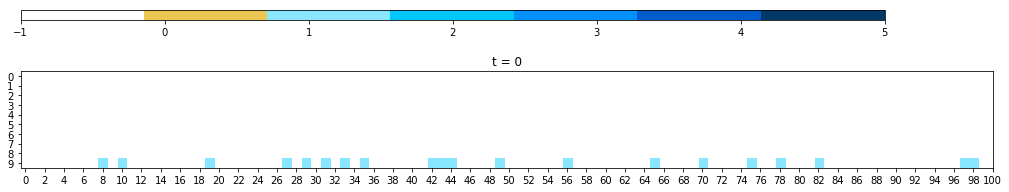

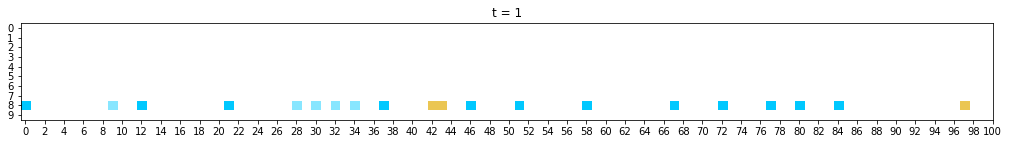

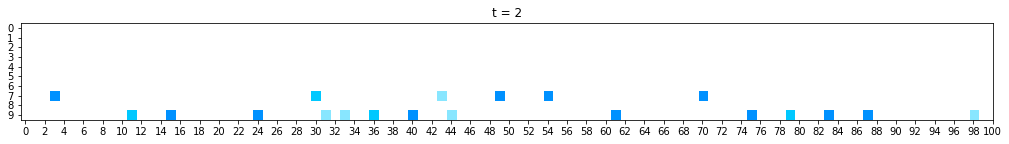

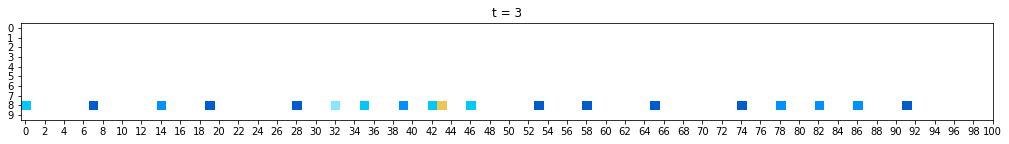

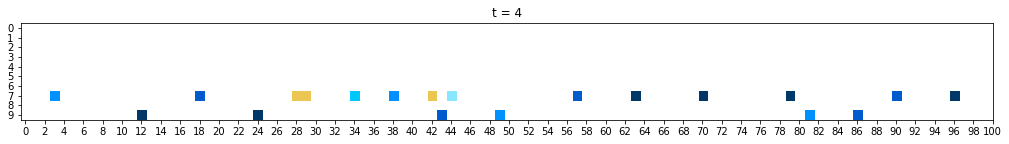

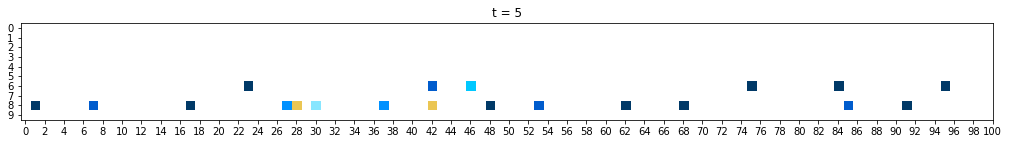

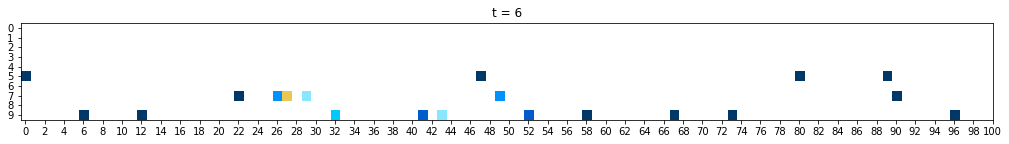

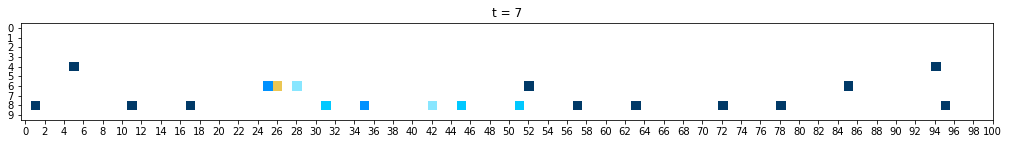

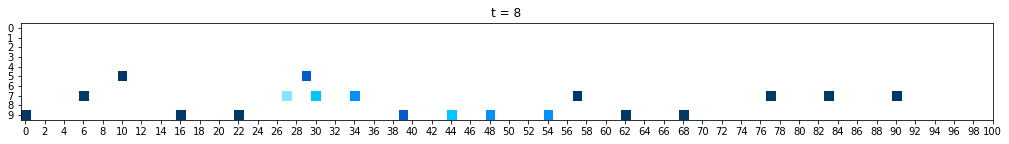

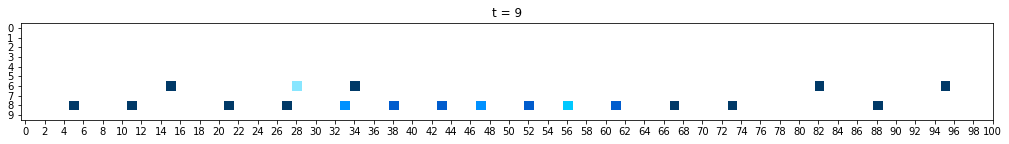

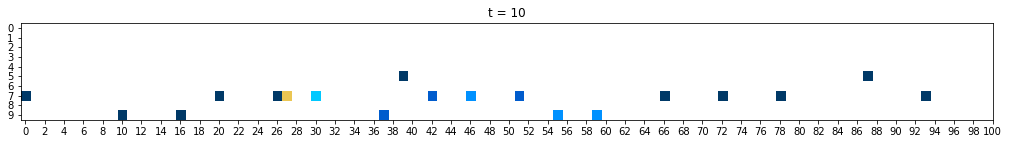

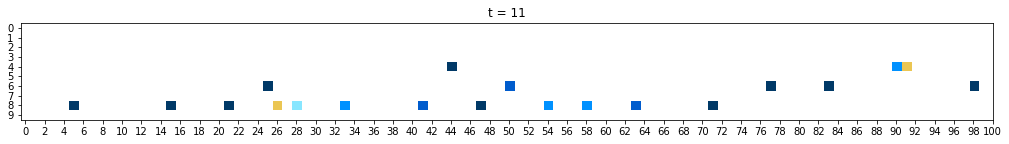

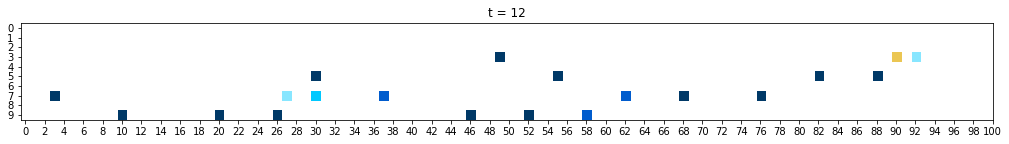

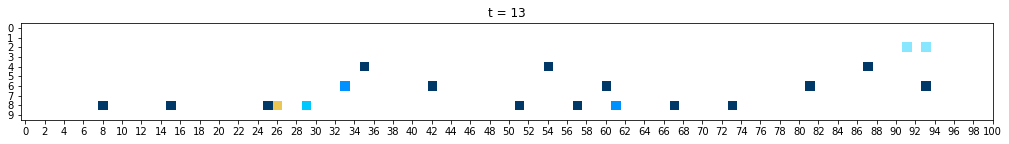

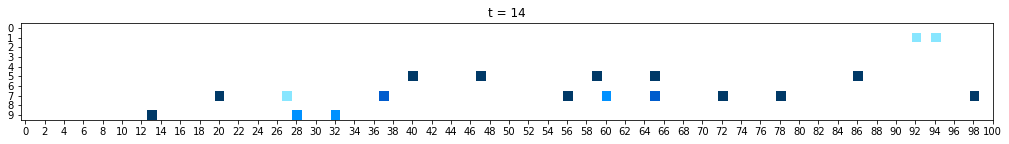

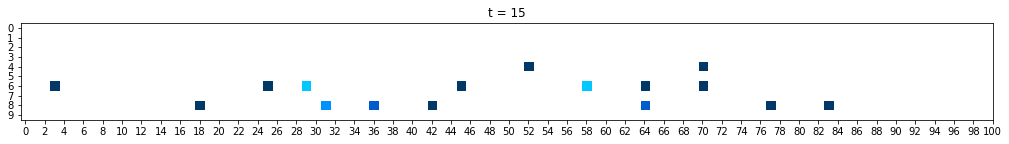

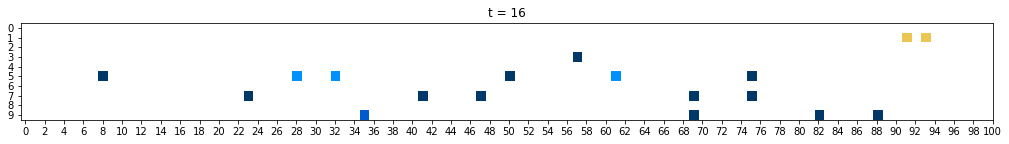

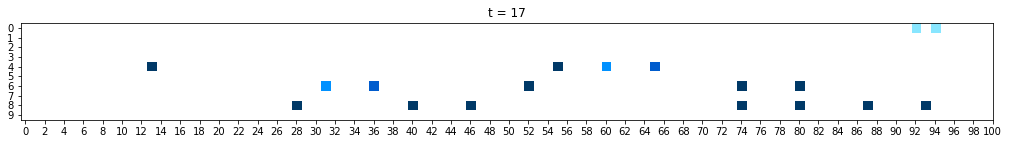

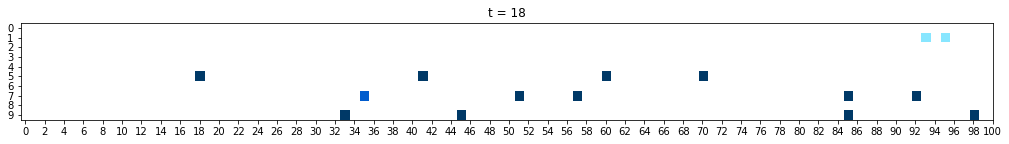

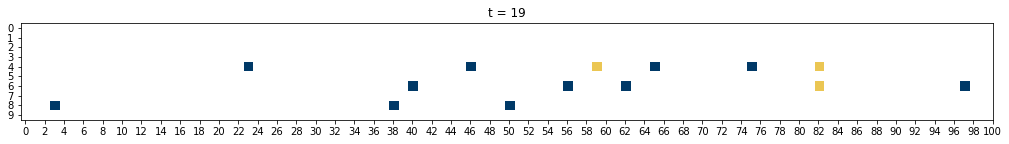

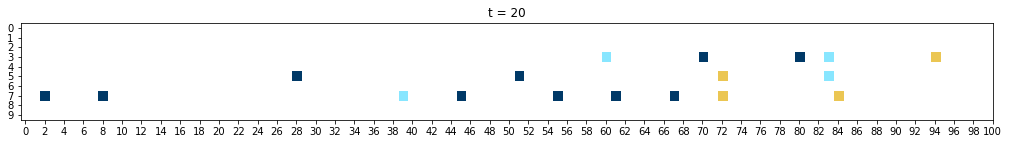

In [948]:
sim = TrafficSimulation(road_size = 100,lanes=10,density = 0.2)
sim.draw()

for _ in range(20):
    sim.update_simulation()
    print(sim.time_step,[(tuple(car.position),car.front_gap) for car in cars])
    print('\n')
    sim.draw()

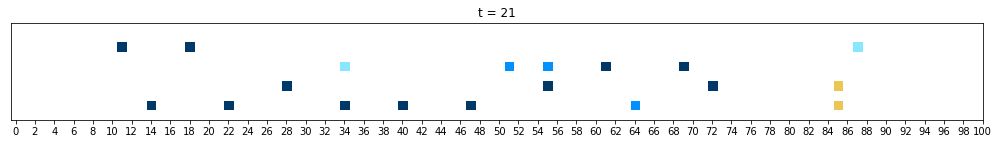

In [915]:
sim.update_simulation()
sim.draw()

In [917]:
print('\n'.join(''.join('.' if x == -1 else str(x) for x in row) for row in sim.road) + "\n")
# bisect_left(sim.car_positions[cars[0].position[0]], cars[0].position[1]) % (sim.road_size-1)

# sim.car_positions[0]

# print(sim.car_positions[3])
# position_front = bisect_left(sim.car_positions[3], 40)

....................................................................................................
....................................................................................................
...........5.0......5.0....................................................................1.0............
....................................................................................................
..................................1.0................3.0...3.0.....5.0.......5.0..............................
....................................................................................................
............................5.0..........................5.0................5.0............0.0..............
....................................................................................................
..............5.0.......5.0...........5.0.....5.0......5.0................3.0....................0.0..............
.....................................................

In [809]:
cars[0].position, 'v=', cars[0].v, 'front gap: ', cars[0].front_gap, 'other gap: ', cars[0].left_gap

AttributeError: 'Car' object has no attribute 'front_gap'

In [523]:
cars[0].front_gap < cars[0].v + 1 and cars[0].other_gap > cars[0].v + 1 #and cars[0].back_gap > cars[0].vmax

False

In [784]:
sim.car_positions[cars[0].position[0]][10]
#bisect_left(sim.car_positions[cars[0].position[0]], 120)

IndexError: list index out of range

In [452]:
(np.array([1,2]) + np.array([2,4])) % (3,1)

array([0, 0])

In [298]:
list(map(lambda x : x.id,list(filter(lambda x : x.lane == 1, cars))))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [281]:
[x.lane for x in cars]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [414]:
example_list = np.array([0,70])
#print(*example_list)
sim.road[tuple(example_list)]
#(np.array([1,2]) + np.array([2,4])) % 4

-1.0

In [685]:
-1 % 100

# road_size = 100
# density = 0.4
# n_cars = round(road_size * density)

# road = -1*np.ones(road_size)

# initial_positions = np.random.choice(range(road_size),n_cars,replace=False)

# cars = [Car(id=i, position= initial_positions[i],vmax=5) for i in range(n_cars)]
# sorted_ids = np.array([car.id for car in sorted(cars, key = lambda x : x.position)])



# print(road)

# for t in range(4):
#     for car in cars:
#         car.update_panorama()
#         car.update_v()
#         car.update_position()

#         road[car.position] = car.v

#     print(road)




# # for i,j in enumerate(sorted_ids):
# #     cars[j].front_car = sorted_ids[(i+1) % n_cars]
# #     cars[j].back_car = sorted_ids[(i-1) % n_cars]


# #     if cars[cars[j].front_car].position > cars[j].position:
# #         cars[j].front_gap = cars[cars[j].front_car].position - cars[j].position - 1
# #     else:
# #         cars[j].front_gap = road_size + (cars[cars[j].front_car].position - cars[j].position) - 1
    

# #     road[cars[j].position] = cars[j].v
    
# # print(road)
    

99

In [689]:
bisect_left([],4)

0

In [694]:
(4 - 2) % 1

0

In [698]:
a = np.array([0,5])

In [699]:
a-=np.array([1,0])

In [742]:
[np.random.choice([1,-1]),0]

[1, 0]

In [794]:
[][0]

IndexError: list index out of range